In [ ]:
!pip install -q scikit-learn

from google.colab import drive
drive.mount('/content/drive')

import os
import json
import numpy as np

BASE = "/content/drive/MyDrive/FitCoach_Project"

# QEVD benchmark folder
QEVD_BENCH_ROOT = f"{BASE}/QEVD/FIT_COACH_BENCHMARK/QEVD-FIT-COACH-Benchmark"

# Folder where we saved MediaPipe pose .npy files
POSE_OUT_DIR    = f"{BASE}/QEVD/pose_long"

print("QEVD_BENCH_ROOT =", QEVD_BENCH_ROOT)
print("POSE_OUT_DIR    =", POSE_OUT_DIR)

print("\nFiles in POSE_OUT_DIR (first 10):")
print(os.listdir(POSE_OUT_DIR)[:10])

print("\nFiles in QEVD_BENCH_ROOT:")
print(os.listdir(QEVD_BENCH_ROOT))

# Long-range feedback JSON path
FB_JSON = os.path.join(QEVD_BENCH_ROOT, "feedbacks_long_range.json")
print("\nFeedback JSON path:", FB_JSON)

with open(FB_JSON, "r") as f:
    raw_fb = json.load(f)

print("Top-level type:", type(raw_fb))
print("Num items (videos):", len(raw_fb))


Mounted at /content/drive
QEVD_BENCH_ROOT = /content/drive/MyDrive/FitCoach_Project/QEVD/FIT_COACH_BENCHMARK/QEVD-FIT-COACH-Benchmark
POSE_OUT_DIR    = /content/drive/MyDrive/FitCoach_Project/QEVD/pose_long

Files in POSE_OUT_DIR (first 10):
['0006_pose.npy', '0009_pose.npy', '0010_pose.npy', '0011_pose.npy', '0012_pose.npy', '0013_pose.npy', '0014_pose.npy', '0015_pose.npy', '0016_pose.npy', '0017_pose.npy']

Files in QEVD_BENCH_ROOT:
['feedbacks_long_range.json', 'long_range_videos']

Feedback JSON path: /content/drive/MyDrive/FitCoach_Project/QEVD/FIT_COACH_BENCHMARK/QEVD-FIT-COACH-Benchmark/feedbacks_long_range.json
Top-level type: <class 'list'>
Num items (videos): 74


In [ ]:
def get_vid_from_path(path: str) -> str:
    """
    Extracting '0006' from './long_range_videos/0006.mp4'
    """
    base = os.path.basename(path)
    vid, _ = os.path.splitext(base)
    return vid

def build_qevd_feedback_entries(raw, bench_root):
    """
    Turning QEVD feedbacks_long_range.json into flat list of dicts,
    {
      "video_id": "0006",
      "time": <absolute timestamp in ns>,
      "text": "First up are high knees!"
    }

    Using 'feedbacks' and 'video_timestamps' (.npy)
    """
    entries = []
    for item in raw:
        #video id
        long_path = item["long_range_video_file"]   # "./long_range_videos/0006.mp4"
        vid = get_vid_from_path(long_path)          # "0006"

        #feedback texts
        fb_list = item["feedbacks"]

        # timestamps
        ts_rel  = item["video_timestamps"]          
        ts_path = os.path.join(bench_root, ts_rel.lstrip("./"))
        ts      = np.load(ts_path)                  

        n = min(len(fb_list), len(ts))
        for i in range(n):
            text = fb_list[i]
            if not text or not text.strip():
                continue  # skipping empty feedback

            t = float(ts[i])  # absolute time in ns
            entries.append({
                "video_id": vid,
                "time": t,
                "text": text.strip(),
            })

    return entries

fb_entries = build_qevd_feedback_entries(raw_fb, QEVD_BENCH_ROOT)
print("Non-empty feedback entries:", len(fb_entries))
if fb_entries:
    print("Example entry:", fb_entries[0])


Non-empty feedback entries: 159855
Example entry: {'video_id': '0006', 'time': 1.7074315067349693e+18, 'text': 'First up are high knees!'}


In [ ]:
pose_cache = {}
ts_cache   = {}

missing_pose = 0
missing_ts   = 0

for item in raw_fb:
    vid = get_vid_from_path(item["long_range_video_file"])

    # Pose file from MediaPipe extraction
    pose_path = os.path.join(POSE_OUT_DIR, f"{vid}_pose.npy")
    if not os.path.isfile(pose_path):
        missing_pose += 1
    else:
        if vid not in pose_cache:
            pose_cache[vid] = np.load(pose_path)   # (num_frames, 33, 4)

    # QEVD timestamp npy
    ts_rel  = item["video_timestamps"]
    ts_path = os.path.join(QEVD_BENCH_ROOT, ts_rel.lstrip("./"))
    if not os.path.isfile(ts_path):
        missing_ts += 1
    else:
        if vid not in ts_cache:
            ts_cache[vid] = np.load(ts_path)       # (num_frames,)

print("Pose cached for videos   :", len(pose_cache))
print("Timestamps cached for vid:", len(ts_cache))
print("Missing pose files:", missing_pose)
print("Missing ts files  :", missing_ts)

# sanity check on one video
some_vid = sorted(pose_cache.keys())[0]
print("\nExample vid:", some_vid)
print("pose shape:", pose_cache[some_vid].shape)
print("ts length:", len(ts_cache[some_vid]), "last ts:", ts_cache[some_vid][-1])


Pose cached for videos   : 74
Timestamps cached for vid: 74
Missing pose files: 0
Missing ts files  : 0

Example vid: 0006
pose shape: (4874, 33, 4)
ts length: 4874 last ts: 1.7074317069628718e+18


In [ ]:
def label_feedback(text: str) -> int:
    """
    Heuristic binary label
      1 = corrective feedback
      0 = non corrective / neutral / praise
    """
    t = text.lower()

    corrective_keywords = [
        "don't", "do not",
        "not moving", "not lifting",
        "too low", "too high", "too fast", "too slow",
        "higher", "lower",
        "move your", "move those",
        "keep your", "keep those",
        "watch your", "careful", "be careful",
        "try to", "make sure", "you need to",
        "fix", "correct", "instead",
        "avoid", "stop",
        "knees higher", "lift your knees",
        "arms up", "arms higher",
        "go deeper", "squat lower",
    ]

    positive_keywords = [
        "great job", "good job", "nice work", "nice job",
        "awesome", "amazing", "excellent",
        "perfect", "looking great", "looking good",
        "keep it up", "keep going", "you got this",
        "well done", "good work", "great work",
    ]

    if any(k in t for k in corrective_keywords):
        return 1

    if any(k in t for k in positive_keywords):
        return 0

    # default: non-corrective
    return 0

# sanity checks
examples = [
    "Go deeper on the squat and punchier on the punches!",
    "Great job, keep it up!",
    "Lift your knees higher!",
]
for s in examples:
    print(s, "->", label_feedback(s))


Go deeper on the squat and punchier on the punches! -> 1
Great job, keep it up! -> 0
Lift your knees higher! -> 1


In [ ]:
def pose_features_for_time(vid, t_center, window_sec=1.5):
    """
    Given video id and an absolute time t_center (QEVD uses ns since epoch),
    returning a feature vector summarizing pose in a +/- window_sec/2
    interval around that time

    Steps:
      1) Finding frame index whose timestamp is closest to t_center
      2) Estimating FPS from timestamp array
      3) Converting time window to frame window
      4) Take that slice and computing mean+std over (x,y,z) per joint

    Returns:
        feat: np.array shape (198,) or None on failure
    """
    pose = pose_cache.get(vid)
    ts_video = ts_cache.get(vid)

    if pose is None or ts_video is None:
        return None

    num_frames = pose.shape[0]
    if num_frames == 0 or len(ts_video) == 0:
        return None

    # timestamps are in nanoseconds since epoch
    ts0    = float(ts_video[0])
    ts_end = float(ts_video[-1])
    duration_sec = (ts_end - ts0) / 1e9
    if duration_sec <= 0:
        return None

    fps = num_frames / duration_sec

    # finding closest frame index to t_center
    diffs = np.abs(ts_video.astype(np.float64) - float(t_center))
    idx_center = int(np.argmin(diffs))

    # time window --> frame window
    half_window_frames = int(max(1, round(window_sec * fps / 2.0)))

    start_idx = max(0, idx_center - half_window_frames)
    end_idx   = min(num_frames, idx_center + half_window_frames + 1)

    if end_idx <= start_idx:
        return None

    window_pose = pose[start_idx:end_idx]    # (W, 33, 4)

    
    xyz = window_pose[..., :3]               # (W, 33, 3)

    mean_xyz = xyz.mean(axis=0).reshape(-1)  # (33*3,)
    std_xyz  = xyz.std(axis=0).reshape(-1)   # (33*3,)

    feat = np.concatenate([mean_xyz, std_xyz], axis=0)  # (33*3*2 = 198,)
    return feat

#test on one feedback entry
for e in fb_entries:
    vid = e["video_id"]
    if vid in pose_cache and vid in ts_cache:
        test_feat = pose_features_for_time(vid, e["time"])
        print("Test feat length:", None if test_feat is None else test_feat.shape)
        break


Test feat length: (198,)


In [ ]:
X_list = []
y_list = []
meta   = []

skipped_no_pose = 0
skipped_no_feat = 0

for fb in fb_entries:
    vid      = fb["video_id"]
    text     = fb["text"]
    t_center = fb["time"]

    # if any video missing pose/ts, skip
    if vid not in pose_cache or vid not in ts_cache:
        skipped_no_pose += 1
        continue

    feat = pose_features_for_time(vid, t_center, window_sec=1.5)
    if feat is None:
        skipped_no_feat += 1
        continue

    label = label_feedback(text)  # 0 or 1

    X_list.append(feat)
    y_list.append(label)
    meta.append({
        "video_id": vid,
        "time": t_center,
        "text": text,
    })

if not X_list:
    print("No examples built – something is wrong (check caches & paths).")
else:
    X = np.vstack(X_list)
    y = np.array(y_list, dtype=np.int64)

    print("Built dataset:")
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    print("Examples skipped (no pose/timestamps):", skipped_no_pose)
    print("Examples skipped (no features/window):", skipped_no_feat)

    unique, counts = np.unique(y, return_counts=True)
    print("\nLabel distribution (0=non-corrective, 1=corrective):")
    for u, c in zip(unique, counts):
        print(f"  {u}: {c}")


Built dataset:
X shape: (159855, 198)
y shape: (159855,)
Examples skipped (no pose/timestamps): 0
Examples skipped (no features/window): 0

Label distribution (0=non-corrective, 1=corrective):
  0: 131279
  1: 28576


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from collections import Counter

(
    X_train, X_test,
    y_train, y_test,
    meta_train, meta_test
) = train_test_split(
    X, y, meta,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])

# Plain logistic regression (no class balancing)
clf = LogisticRegression(max_iter=200, n_jobs=-1)
clf.fit(X_train, y_train)

print("\n[Plain LogReg]")
print("Train accuracy:", clf.score(X_train, y_train))
print("Test accuracy :", clf.score(X_test, y_test))

y_pred = clf.predict(X_test)
print("\nClassification report (plain logreg):")
print(classification_report(y_test, y_pred, digits=3))

# Showing class imbalance and baseline accuracy
print("\nLabel distribution in y (0=non-corrective, 1=corrective):")
cnt = Counter(y)
for k, v in cnt.items():
    print(f"  {k}: {v} ({v / len(y):.3f} fraction)")

majority_class, majority_count = cnt.most_common(1)[0]
maj_acc = majority_count / len(y)
print("\nMajority class:", majority_class)
print("Majority-baseline accuracy if we always predict this class:", maj_acc)


Train size: 127884
Test size : 31971

[Plain LogReg]
Train accuracy: 0.8207985361734071
Test accuracy : 0.8207125207219043

Classification report (plain logreg):
              precision    recall  f1-score   support

           0      0.823     0.997     0.901     26256
           1      0.444     0.012     0.023      5715

    accuracy                          0.821     31971
   macro avg      0.633     0.504     0.462     31971
weighted avg      0.755     0.821     0.744     31971


Label distribution in y (0=non-corrective, 1=corrective):
  0: 131279 (0.821 fraction)
  1: 28576 (0.179 fraction)

Majority class: 0
Majority-baseline accuracy if we always predict this class: 0.8212379969347221


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Balanced logistic regression
clf_bal = LogisticRegression(
    max_iter=300,
    n_jobs=-1,
    class_weight="balanced"
)
clf_bal.fit(X_train, y_train)

print("[Balanced LogReg]")
print("Train accuracy:", clf_bal.score(X_train, y_train))
print("Test accuracy :", clf_bal.score(X_test, y_test))

y_pred_bal = clf_bal.predict(X_test)
print("\nBalanced logistic – classification report (default threshold 0.5):")
print(classification_report(y_test, y_pred_bal, digits=3))

#threshold sweep on probabilities for class 1
y_proba = clf_bal.predict_proba(X_test)[:, 1]

best_tau = 0.5
best_f1 = -1
records = []

for tau in np.linspace(0.05, 0.95, 19):  # thresholds from 0.05 to 0.95
    y_pred_tau = (y_proba >= tau).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_tau, average=None, labels=[0, 1]
    )
    # index 1 = class 1 (corrective)
    p1, r1, f1_1 = precision[1], recall[1], f1[1]
    records.append((tau, p1, r1, f1_1))
    if f1_1 > best_f1:
        best_f1 = f1_1
        best_tau = tau

print(f"\nBest threshold for class 1 F1: tau={best_tau:.2f}, F1={best_f1:.3f}")

print("\nSome thresholds (tau, precision_1, recall_1, F1_1):")
for tau, p1, r1, f1_1 in records[::3]:  # printing every 3rd
    print(f"  {tau:.2f} -> P1={p1:.3f}, R1={r1:.3f}, F1_1={f1_1:.3f}")

# Classification report at best tau
tau = best_tau
y_pred_best = (y_proba >= tau).astype(int)

print(f"\nClassification report at tau={tau:.2f}:")
print(classification_report(y_test, y_pred_best, digits=3))


[Balanced LogReg]
Train accuracy: 0.644764004879422
Test accuracy : 0.6429576803978606

Balanced logistic – classification report (default threshold 0.5):
              precision    recall  f1-score   support

           0      0.887     0.648     0.749     26256
           1      0.277     0.621     0.383      5715

    accuracy                          0.643     31971
   macro avg      0.582     0.634     0.566     31971
weighted avg      0.778     0.643     0.683     31971


Best threshold for class 1 F1: tau=0.50, F1=0.383

Some thresholds (tau, precision_1, recall_1, F1_1):
  0.05 -> P1=0.179, R1=1.000, F1_1=0.303
  0.20 -> P1=0.181, R1=0.995, F1_1=0.307
  0.35 -> P1=0.207, R1=0.924, F1_1=0.338
  0.50 -> P1=0.277, R1=0.621, F1_1=0.383
  0.65 -> P1=0.354, R1=0.240, F1_1=0.286
  0.80 -> P1=0.363, R1=0.022, F1_1=0.042
  0.95 -> P1=0.000, R1=0.000, F1_1=0.000

Classification report at tau=0.50:
              precision    recall  f1-score   support

           0      0.887     0.648   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def show_examples(n=10, tau=None, positive_only=True):
    """
    Printing some test examples with the following
      - video id
      - true label
      - predicted label
      - text
    """
    if tau is None:
        y_pred_used = clf_bal.predict(X_test)
    else:
        y_proba = clf_bal.predict_proba(X_test)[:, 1]
        y_pred_used = (y_proba >= tau).astype(int)

    shown = 0
    for i in range(len(X_test)):
        y_true_i = y_test[i]
        y_pred_i = y_pred_used[i]

        if positive_only and y_pred_i != 1:
            continue

        m = meta_test[i]
        print("=" * 80)
        print(f"Example #{i}")
        print(f"Video id   : {m['video_id']}")
        print(f"True label : {y_true_i} (1=corrective)")
        print(f"Pred label : {y_pred_i}")
        print("Text       :", m['text'])
        print("=" * 80)
        shown += 1
        if shown >= n:
            break

print("Examples where model predicts corrective at tau=0.5:")
show_examples(n=5, tau=0.5, positive_only=True)

print("\nExamples where model predicts corrective at best tau:")
show_examples(n=5, tau=best_tau, positive_only=True)


Examples where model predicts corrective at tau=0.5:
Example #8
Video id   : 0056
True label : 0 (1=corrective)
Pred label : 1
Text       : That's 10 reps. Awesome! Keep it going to the end.
Example #9
Video id   : 0011
True label : 0 (1=corrective)
Pred label : 1
Text       : Alright, we've got the leg up.
Example #11
Video id   : 0024
True label : 0 (1=corrective)
Pred label : 1
Text       : Moving on to butt kickers!
Example #15
Video id   : 0194
True label : 0 (1=corrective)
Pred label : 1
Text       : Yes! That's it. Feel that pull in your shoulder!
Example #19
Video id   : 0054
True label : 0 (1=corrective)
Pred label : 1
Text       : Take your feet wider apart so you can get nice and low in that lunge.

Examples where model predicts corrective at best tau:
Example #8
Video id   : 0056
True label : 0 (1=corrective)
Pred label : 1
Text       : That's 10 reps. Awesome! Keep it going to the end.
Example #9
Video id   : 0011
True label : 0 (1=corrective)
Pred label : 1
Text       : A

In [ ]:
from sklearn.metrics import confusion_matrix

# Using best threshold
y_pred_best = (clf_bal.predict_proba(X_test)[:, 1] >= best_tau).astype(int)

cm = confusion_matrix(y_test, y_pred_best, labels=[0, 1])
print("Confusion matrix (rows=true, cols=pred):\n", cm)

cm_norm = cm / cm.sum(axis=1, keepdims=True)
print("\nRow-normalized confusion matrix:\n", cm_norm)


Confusion matrix (rows=true, cols=pred):
 [[17007  9249]
 [ 2166  3549]]

Row-normalized confusion matrix:
 [[0.64773766 0.35226234]
 [0.37900262 0.62099738]]


In [ ]:
#PHASE 2

In [ ]:
import os
import numpy as np

SAVE_DIR = os.path.join(BASE, "QEVD")
os.makedirs(SAVE_DIR, exist_ok=True)

np.savez(
    os.path.join(SAVE_DIR, "pose_feedback_dataset_v1.npz"),
    X=X,
    y=y
)

with open(os.path.join(SAVE_DIR, "logreg_summary.txt"), "w") as f:
    f.write("Balanced logistic, tau = {:.2f}\n".format(best_tau))
    f.write("Confusion matrix (rows=true, cols=pred):\n")
    f.write(str(cm) + "\n\n")
    f.write("Row-normalized confusion matrix:\n")
    f.write(str(cm_norm) + "\n")

print("Saved dataset + summary in:", SAVE_DIR)


Saved dataset + summary in: /content/drive/MyDrive/FitCoach_Project/QEVD


Explained variance ratios: [0.41969046 0.26680103]


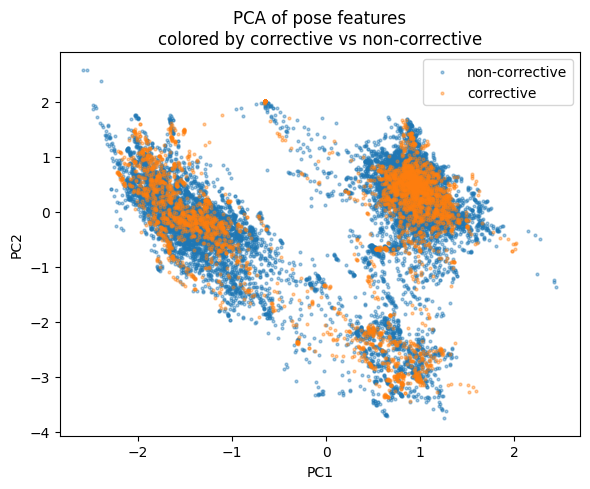

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# subsample to keep plot readable
N_VIS = 20000
idx = np.random.choice(len(X), size=min(N_VIS, len(X)), replace=False)
X_small = X[idx]
y_small = y[idx]

pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_small)

print("Explained variance ratios:", pca.explained_variance_ratio_)

plt.figure(figsize=(6, 5))
for label, color, name in [(0, "tab:blue", "non-corrective"),
                           (1, "tab:red",  "corrective")]:
    mask = (y_small == label)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                s=4, alpha=0.4, label=name)

plt.legend()
plt.title("PCA of pose features\ncolored by corrective vs non-corrective")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    batch_size=512,
    max_iter=20,
    alpha=1e-4,
    learning_rate_init=1e-3,
    early_stopping=True,
    n_iter_no_change=3,
    verbose=True,
    random_state=0
)

mlp.fit(X_train, y_train)

print("\n[MLP on pose features]")
print("Train accuracy:", mlp.score(X_train, y_train))
print("Test  accuracy:", mlp.score(X_test, y_test))

y_pred_mlp = mlp.predict(X_test)
print("\nMLP – classification report:")
print(classification_report(y_test, y_pred_mlp, digits=3))


Iteration 1, loss = 0.46193492
Validation score: 0.821253
Iteration 2, loss = 0.43865749
Validation score: 0.823755
Iteration 3, loss = 0.42714148
Validation score: 0.826961
Iteration 4, loss = 0.41646931
Validation score: 0.827430
Iteration 5, loss = 0.40499607
Validation score: 0.829932
Iteration 6, loss = 0.39345485
Validation score: 0.840253
Iteration 7, loss = 0.38253002
Validation score: 0.843616
Iteration 8, loss = 0.37187398
Validation score: 0.840879
Iteration 9, loss = 0.35947015
Validation score: 0.841895
Iteration 10, loss = 0.35240373
Validation score: 0.846900
Iteration 11, loss = 0.34287975
Validation score: 0.853859
Iteration 12, loss = 0.33367225
Validation score: 0.859958
Iteration 13, loss = 0.32873685
Validation score: 0.856126
Iteration 14, loss = 0.32189080
Validation score: 0.855892
Iteration 15, loss = 0.31594345
Validation score: 0.859958
Iteration 16, loss = 0.30990728
Validation score: 0.866448
Iteration 17, loss = 0.30329956
Validation score: 0.870514
Iterat

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Train accuracy: 0.8792108473303931
Test  accuracy: 0.8755121829157674

MLP – classification report:
              precision    recall  f1-score   support

           0      0.882     0.979     0.928     26256
           1      0.808     0.398     0.534      5715

    accuracy                          0.876     31971
   macro avg      0.845     0.689     0.731     31971
weighted avg      0.869     0.876     0.858     31971



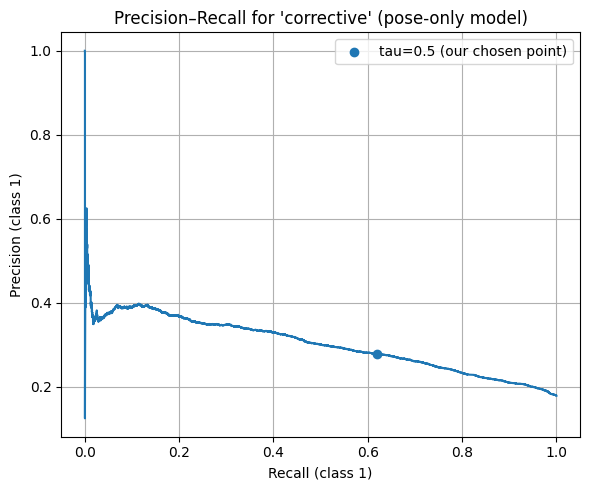

In [ ]:
from sklearn.metrics import precision_recall_curve

# Probabilities for class 1 from balanced logreg
y_scores = clf_bal.predict_proba(X_test)[:, 1]
prec, rec, thresh = precision_recall_curve(y_test, y_scores, pos_label=1)

plt.figure(figsize=(6, 5))
plt.plot(rec, prec)
plt.scatter([0.62], [0.277], label="tau=0.5 (our chosen point)")
plt.xlabel("Recall (class 1)")
plt.ylabel("Precision (class 1)")
plt.title("Precision–Recall for 'corrective' (pose-only model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from collections import defaultdict
from sklearn.metrics import f1_score

# reusing best-tau predictions
y_pred_best = (clf_bal.predict_proba(X_test)[:, 1] >= best_tau).astype(int)

per_vid_true = defaultdict(list)
per_vid_pred = defaultdict(list)

for m, yt, yp in zip(meta_test, y_test, y_pred_best):
    vid = m["video_id"]
    per_vid_true[vid].append(yt)
    per_vid_pred[vid].append(yp)

rows = []
for vid in sorted(per_vid_true.keys()):
    yt = np.array(per_vid_true[vid])
    yp = np.array(per_vid_pred[vid])
    if len(np.unique(yt)) < 2:
        # F1 undefined if only one class; skipping those or treating as 0
        continue
    f1 = f1_score(yt, yp, pos_label=1)
    rows.append((vid, len(yt), f1))

rows_sorted = sorted(rows, key=lambda x: x[2], reverse=True)

print("Per-video F1 for 'corrective' (only videos with both classes present):")
for vid, n, f1 in rows_sorted[:10]:
    print(f"  vid {vid}: n={n:4d}, F1_1={f1:.3f}")
print("...")
for vid, n, f1 in rows_sorted[-10:]:
    print(f"  vid {vid}: n={n:4d}, F1_1={f1:.3f}")


Per-video F1 for 'corrective' (only videos with both classes present):
  vid 0077: n= 397, F1_1=0.620
  vid 0155: n= 530, F1_1=0.600
  vid 0170: n= 485, F1_1=0.540
  vid 0014: n= 343, F1_1=0.538
  vid 0169: n= 467, F1_1=0.529
  vid 0204: n= 446, F1_1=0.520
  vid 0145: n= 515, F1_1=0.515
  vid 0028: n= 318, F1_1=0.508
  vid 0031: n= 532, F1_1=0.502
  vid 0193: n= 432, F1_1=0.498
...
  vid 0027: n= 435, F1_1=0.235
  vid 0030: n= 479, F1_1=0.229
  vid 0146: n= 470, F1_1=0.202
  vid 0185: n= 419, F1_1=0.175
  vid 0023: n= 397, F1_1=0.162
  vid 0197: n= 479, F1_1=0.162
  vid 0053: n= 320, F1_1=0.154
  vid 0078: n= 342, F1_1=0.145
  vid 0073: n= 267, F1_1=0.133
  vid 0212: n= 500, F1_1=0.118


In [ ]:
#Results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np

BASE = "/content/drive/MyDrive/FitCoach_Project"
DATA_PATH = os.path.join(BASE, "QEVD", "pose_feedback_dataset_v1.npz")

data = np.load(DATA_PATH, allow_pickle=True)
X = data["X"]
y = data["y"]

print("X shape:", X.shape)
print("y shape:", y.shape)
unique, counts = np.unique(y, return_counts=True)
print("Label distribution:")
for u, c in zip(unique, counts):
    print(f"  {u}: {c} ({c/len(y):.3f})")


Mounted at /content/drive
X shape: (159855, 198)
y shape: (159855,)
Label distribution:
  0: 131279 (0.821)
  1: 28576 (0.179)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape[0])
print("Test  size:", X_test.shape[0])


Train size: 127884
Test  size: 31971


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf_bal = LogisticRegression(
    max_iter=300,
    n_jobs=-1,
    class_weight="balanced"
)
clf_bal.fit(X_train, y_train)

print("[Balanced LogReg]")
print("Train accuracy:", clf_bal.score(X_train, y_train))
print("Test  accuracy:", clf_bal.score(X_test, y_test))

y_pred_log = clf_bal.predict(X_test)
print("\nClassification report (LogReg):")
print(classification_report(y_test, y_pred_log, digits=3))


[Balanced LogReg]
Train accuracy: 0.644764004879422
Test  accuracy: 0.6429576803978606

Classification report (LogReg):
              precision    recall  f1-score   support

           0      0.887     0.648     0.749     26256
           1      0.277     0.621     0.383      5715

    accuracy                          0.643     31971
   macro avg      0.582     0.634     0.566     31971
weighted avg      0.778     0.643     0.683     31971



In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation="relu",
    solver="adam",
    batch_size=512,
    max_iter=20,
    verbose=True,
    random_state=42,
)
mlp.fit(X_train, y_train)

print("\n[MLP on pose features]")
print("Train accuracy:", mlp.score(X_train, y_train))
print("Test  accuracy:", mlp.score(X_test, y_test))

y_pred_mlp = mlp.predict(X_test)
print("\nClassification report (MLP):")
print(classification_report(y_test, y_pred_mlp, digits=3))


Iteration 1, loss = 0.45230532
Iteration 2, loss = 0.42805968
Iteration 3, loss = 0.41066687
Iteration 4, loss = 0.39018912
Iteration 5, loss = 0.37163885
Iteration 6, loss = 0.35680723
Iteration 7, loss = 0.34003644
Iteration 8, loss = 0.32513521
Iteration 9, loss = 0.31269306
Iteration 10, loss = 0.30282698
Iteration 11, loss = 0.28914708
Iteration 12, loss = 0.27989105
Iteration 13, loss = 0.27053344
Iteration 14, loss = 0.26269369
Iteration 15, loss = 0.25530608
Iteration 16, loss = 0.24728205
Iteration 17, loss = 0.23825539
Iteration 18, loss = 0.23401650
Iteration 19, loss = 0.22531264
Iteration 20, loss = 0.22358958

[MLP on pose features]


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Train accuracy: 0.905351725000782
Test  accuracy: 0.9019736636326671

Classification report (MLP):
              precision    recall  f1-score   support

           0      0.907     0.982     0.943     26256
           1      0.865     0.535     0.661      5715

    accuracy                          0.902     31971
   macro avg      0.886     0.758     0.802     31971
weighted avg      0.899     0.902     0.892     31971



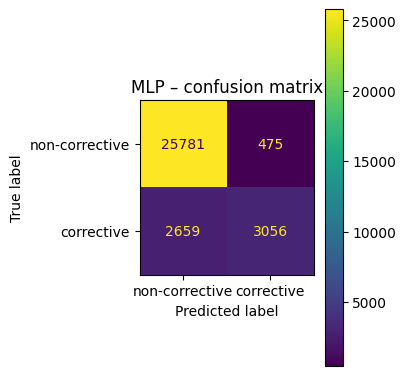

Saved figure: cm_mlp.png


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_mlp, labels=[0, 1])

fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["non-corrective", "corrective"]
)
disp.plot(ax=ax, values_format="d")
plt.title("MLP – confusion matrix")
plt.tight_layout()
plt.savefig("cm_mlp.png", dpi=200)
plt.show()

print("Saved figure: cm_mlp.png")


Average precision (AP) for class 1: 0.8251023958352609
At tau=0.5: P1=0.865, R1=0.535, F1_1=0.661


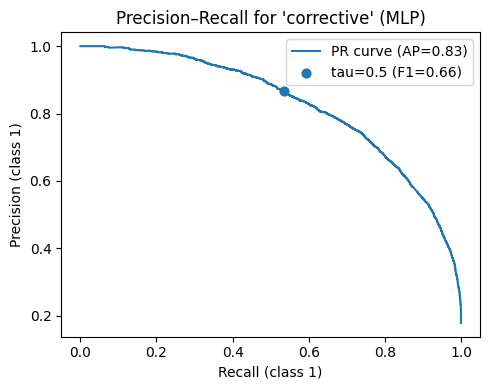

Saved figure: pr_curve_corrective.png


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_recall_fscore_support

y_scores = mlp.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)
print("Average precision (AP) for class 1:", ap)

# PR at threshold tau=0.5 (for the dot on the curve)
import numpy as np
tau = 0.5
y_pred_tau = (y_scores >= tau).astype(int)
p1, r1, f1_1, _ = precision_recall_fscore_support(
    y_test, y_pred_tau, labels=[1], average=None
)
p1, r1, f1_1 = p1[0], r1[0], f1_1[0]
print(f"At tau={tau}: P1={p1:.3f}, R1={r1:.3f}, F1_1={f1_1:.3f}")

plt.figure(figsize=(5, 4))
plt.plot(recall, precision, label=f"PR curve (AP={ap:.2f})")
plt.scatter(r1, p1, s=40, label=f"tau={tau} (F1={f1_1:.2f})")
plt.xlabel("Recall (class 1)")
plt.ylabel("Precision (class 1)")
plt.title("Precision–Recall for 'corrective' (MLP)")
plt.legend()
plt.tight_layout()
plt.savefig("pr_curve_corrective.png", dpi=200)
plt.show()

print("Saved figure: pr_curve_corrective.png")


Explained variance ratios: [0.41891274 0.2684738 ]


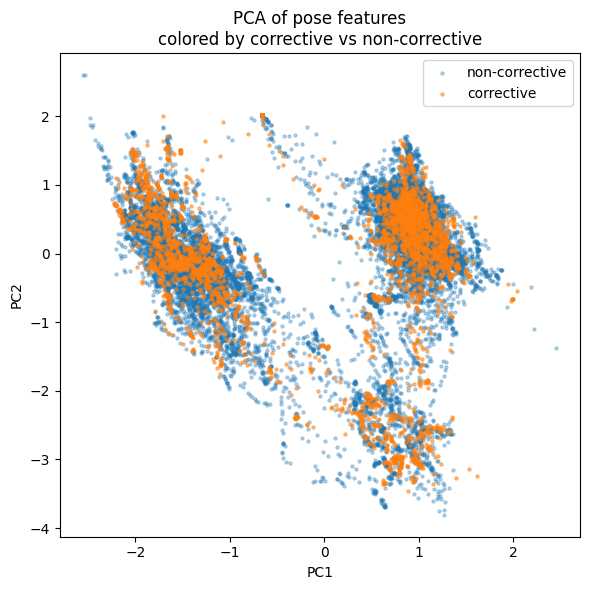

Saved figure: pca_pose.png


In [ ]:
from sklearn.decomposition import PCA

# Subsample for plotting to keep it light
n_plot = min(20000, len(X))
idx = np.random.choice(len(X), size=n_plot, replace=False)
X_plot = X[idx]
y_plot = y[idx]

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_plot)
print("Explained variance ratios:", pca.explained_variance_ratio_)

mask0 = (y_plot == 0)
mask1 = (y_plot == 1)

plt.figure(figsize=(6, 6))
plt.scatter(X_pca[mask0, 0], X_pca[mask0, 1], s=5, alpha=0.3, label="non-corrective")
plt.scatter(X_pca[mask1, 0], X_pca[mask1, 1], s=5, alpha=0.5, label="corrective")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of pose features\ncolored by corrective vs non-corrective")
plt.legend()
plt.tight_layout()
plt.savefig("pca_pose.png", dpi=200)
plt.show()

print("Saved figure: pca_pose.png")
